# Exploratory Data Analysis

In [1]:
from zipfile import ZipFile
import json
import wget
import os
from collections import Counter
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

## The Data

CUAD: An Expert-Annotated NLP Dataset for Legal Contract Review

https://arxiv.org/abs/2103.06268

This code is an adaptation of the scrape.py file avaliable on the github repository for CUAD.  It has been adapted to run in Jypter notebooks and allow us to step throght the coding line by line.`

### Download repository and extract data

In [2]:
def extract_zip(pth,data_pth = None):
    """Function to extract contents of a zip file to a specified location (wd if data_pth not passed)"""
    with ZipFile(pth, 'r') as zipObj:
       # Extract all the contents of zip file in different directory
       zipObj.extractall(data_pth)

In [3]:
#If it does not already exist, download CUAD git repository
if not os.path.isdir('cuad-main'):
    wget.download('https://github.com/TheAtticusProject/cuad/archive/refs/heads/main.zip')
    extract_zip('main.zip')

In [4]:
#If it has not already been extracted, extract the contents of data.zip
if not os.path.isdir('cuad-main/data'):
    os.makedirs('cuad-main/data')
    extract_zip('cuad-main/data.zip','cuad-main/data/')

### Load CUADv1.json data

In [5]:
#Load CUADv1 JSON to data
with open('cuad-main/data/CUADv1.json','r') as infile:
    for line in infile:
        data = json.loads(line)

#### Examples of data within the data dictionary

In [6]:
print('Title:',data['data'][0]['title'])
print('Question:',data['data'][0]['paragraphs'][0]['qas'][0]['question'])
print('Is_Possible:',data['data'][0]['paragraphs'][0]['qas'][0]['is_impossible'])

Title: LIMEENERGYCO_09_09_1999-EX-10-DISTRIBUTOR AGREEMENT
Question: Highlight the parts (if any) of this contract related to "Document Name" that should be reviewed by a lawyer. Details: The name of the contract
Is_Possible: False


In [7]:
#Determine number of contracts within the data dictionary
contracts = len(data['data'])
print('There are {} contracts in the data set'.format(contracts))

There are 510 contracts in the data set


#### Explore the responses within the data

In [8]:
#Initate lists to store responses
titles =[]
paragraph_len = []
qas_len = []
clause = []
clause_found = []

#For each contract in the data
for i in range(contracts):
    #Append the title to titles
    titles.append(data['data'][i]['title'])
    
    #Append the length of the paragraph key to the data to paragraph_len
    paragraph_len.append(len(data['data'][i]['paragraphs']))
    
    #Append the number of clauses investigated for each contract to qas_len
    qas_len.append(len(data['data'][i]['paragraphs'][0]['qas']))
    
    #Initate lists for the contract to capture clauses investigated and if responses found in contract
    contract_clause= []
    contract_clause_found = []
    
    #For each clause investigated in contract
    for j in range(len(data['data'][i]['paragraphs'][0]['qas'])):
        
        #Extract the specific clause from the question key using regex (clause always "quoted")
        q_text = data['data'][i]['paragraphs'][0]['qas'][j]['question']
        #Append clause to contract_clause list
        contract_clause.append(re.search(r'"(.*?)"', q_text)[0].replace('"',''))
        
        #Identify if clause found in cotnract and append to contract_clause_found list
        contract_clause_found.append(data['data'][i]['paragraphs'][0]['qas'][j]['is_impossible'])
    
    #Append overal conract lists to clause and clause found lists (list within a list)
    clause.append(contract_clause)
    clause_found.append(contract_clause_found)
    
#Define function to flatten a list
flatten = lambda t: [item for sublist in t for item in sublist]

#Count total responses
responded = Counter(flatten(clause_found))

#To simplify analysis convert clause and clause_found to np.arrays
clause = np.array(clause)
clause_found = np.array(clause_found)

In [9]:
#Initate lists to store the specific clauses found and totals
clauses_found = []
clauses_found_num = []

#For each contract, produce lists of the specific clauses and total number found
for j in range(contracts):
    clauses_found.append(clause[j][clause_found[j]])
    clauses_found_num.append(len(clause[j][clause_found[j]]))

In [18]:
#Output Summary Analysis
print('Each contract has minimum of {} questions answered'.format(min(qas_len)))
print('Each contract has maximum of {} questions answered'.format(max(qas_len)))
print('Of the {} questions asked in total, {} have had responses found'.format(*(contracts*max(qas_len),responded[False])))

Each contract has minimum of 41 questions answered
Each contract has maximum of 41 questions answered
Of the 20910 questions asked in total, 6702 have had responses found


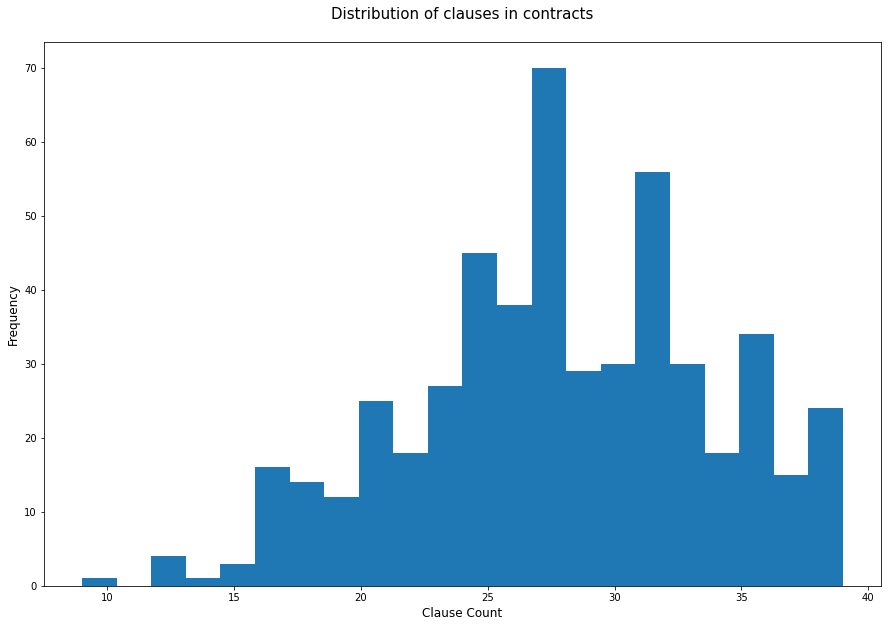

In [11]:
plt.figure(figsize=(15,10))
plt.title('Distribution of clauses in contracts\n',size = 15)
plt.hist(clauses_found_num,bins=22)
plt.xlabel('Clause Count',size = 12)
plt.ylabel('Frequency',size = 12)
plt.show()

#### Labeling Data

A manual mapping exercise has been completed to map the contract title to one of the know contract classes.  In most cases a direct mapping can be made.  in c80% of cases a decision has been made by the labeller regarding where to best map the data.

This shows that with minimal intervention, Figure 3 can be recovered from the CUAD data

In [12]:
#Correct for a single identified edgecase in the data
titles = [x.replace('É','E') for x in titles]

#Read in and build a mapping from titles to label
label_LU = {}

with open('labels3.txt','r') as infile:
    for line in infile:
        label_data = line.strip().replace('"','').split(sep='\t')
        label_LU[(label_data[0])] = label_data[1]
        
#label data with imported labels
labels = [label_LU[x] for x in titles]

In [13]:
#Output count analysis of labels
label_counts = Counter(labels)
pd.DataFrame(label_counts.values(),index=label_counts.keys(),columns=['counts'])

,counts
distributor agreement,32
promotion agreement,12
supply agreement,18
hosting agreement,20
joint venture agreement,23
endorsement agreement,24
consulting agreement,11
marketing agreement,17
strategic alliance agreement,32
sponsorship agreement,31


## Build Labled Data Of Annotations

In [14]:
from collections import defaultdict

In [21]:
contract_data =defaultdict(list)
check_count = 0
#For each contract in the data
for i in range(contracts):
    c_title = titles[i]
    c_label = labels[i] 
    
    for j in range(len(data['data'][i]['paragraphs'][0]['qas'])):
        
        q_text = data['data'][i]['paragraphs'][0]['qas'][j]['question']
        c_clause = re.search(r'"(.*?)"', q_text)[0].replace('"','')
        
        if not data['data'][i]['paragraphs'][0]['qas'][j]['is_impossible']:
            check_count += 1
        
            for k in range(len(data['data'][i]['paragraphs'][0]['qas'][j]['answers'])):

                c_text = data['data'][i]['paragraphs'][0]['qas'][j]['answers'][k]['text']
                
                contract_data['contract'].append(c_title)
                contract_data['type'].append(c_label)
                contract_data['clause'].append(c_clause)
                contract_data['text'].append(str(c_text))
            
"""EXPORT DATA AS JSON"""

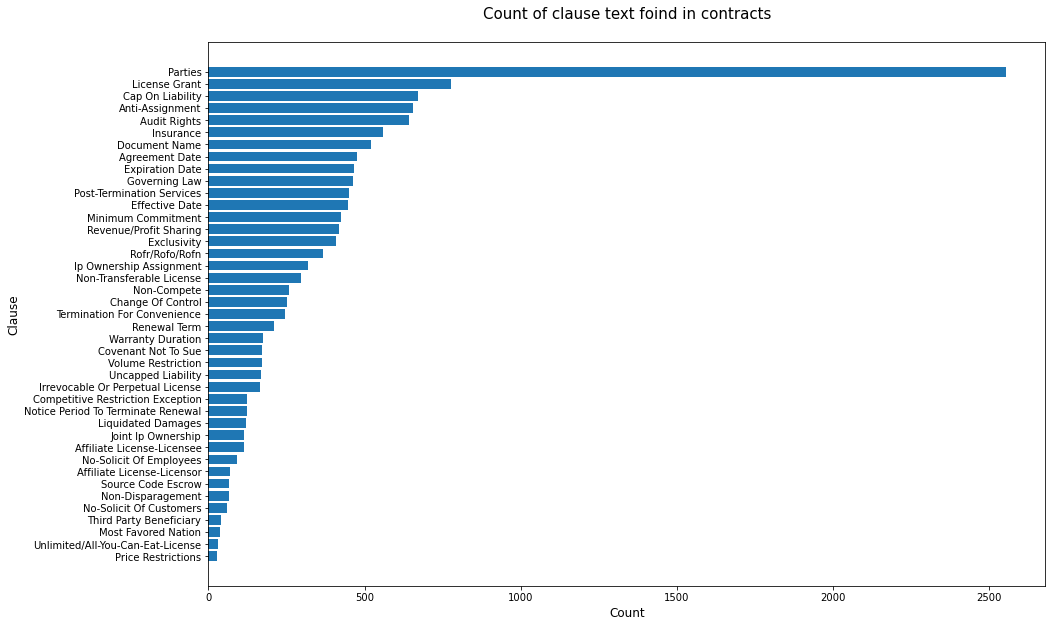

In [48]:
#Build dataframe of clause data
clause_data = pd.DataFrame(contract_data)

#determine counts of clauses and sort by count results
cl, cl_count = np.unique(clause_data['clause'],return_counts=True)
idx = np.argsort(cl_count)
cl, cl_count = cl[idx],cl_count[idx] 

#Plot sorted count volumes
plt.figure(figsize=(15,10))
plt.barh(cl, cl_count)
plt.title('Count of clause text foind in contracts\n',size = 15)
plt.xlabel('Count',size = 12)
plt.ylabel('Clause',size = 12)
plt.show()